## Demonstration notebook for TreeLS
This notebook will outline the tree species classification process, from raw point clouds of individual trees through predicting with a trained model. <br/>

For this notebook, the following file/folder structure is used: <br/>

<pre>
|-- LICENSE 
|-- README.md 
|-- TreeLS.yml 
| 
|-- data 
|   |-- treesXYZ 
|       |-- tree_id1.txt --> .txt files with containing point cloud data 
|                             i.e x1 y1 z1
|                                 x2 y2 z2
|       |-- tree_id2.txt      
|       |-- ... 
|
|   |-- meta
|       |-- tree-meta.csv --> metadata file describing species for each sample in treesXYZ
|                             it should have two columns 'id' and 'sp' containing identifiers and species labels
|                             with the id matching the filename for the corresponding pointcloud (w/o file extension)
|
|                             e.g. 
|                             id	    sp
|                             tree_id1	QUEFAG
|                             ...
| 
|-- utils 
|   |-- __init__.py 
|   |-- dataset.py 
|   |-- utils.py 
|   |-- train.py 
|   |-- test.py 
| 
|-- sh 
|   |-- dl-simpleview.sh 
</pre>

Before running anything, the code for the core model needs to be pulled:

In [1]:
# #Clone Simpleview repo
# !git clone https://github.com/IsaacCorley/simpleview-pytorch

# !cd simpleview-pytorch

# #Remove git stuff + non-classification bits
# !rm -r assets
# !rm -f LICENSE
# !rm -f README.md
# !rm -f .gitignore

# !cd ..

# !mv simpleview-pytorch/simpleview_pytorch simpleview_pytorch
# !rm -r -f simpleview-pytorch

In [1]:
#Imports
import shutil, os
import numpy as np
import utils
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

/home/matt/miniconda3/envs/tlspecies/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
torch. __version__

'1.12.1+cu113'

We'll start by taking a look at some of the data:

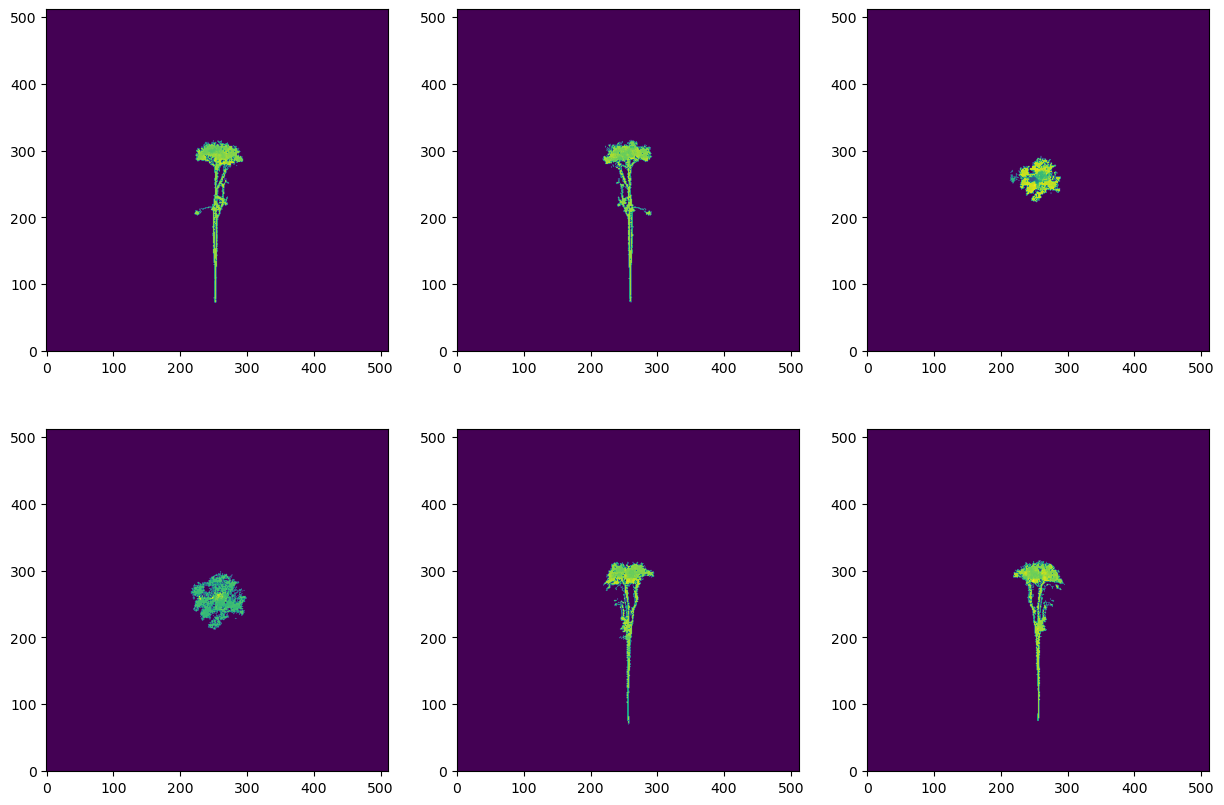

In [5]:
cloud = utils.pc_from_txt("data/Tr3D_species/treesXYZ/70.txt") #Load from file
cloud = utils.center_and_scale(cloud) #Center and scale into [-1,1]^3

sample_images = utils.get_depth_images_from_cloud(cloud, image_dim=512) #Generate the projections
fig, ax = utils.plot_depth_images(sample_images, nrows=2)

Our data isn't split into train/validation/test sets, so we'll do it randomly here. Since the dataset we used in the paper was quite large, the class balance turns out about the same without the need for stratified sampling. If you want to use specific samples in the train/test sets, it's fine to separate the folders by hand - just skip the two cells below.

In [6]:
filenames = os.listdir("data/Tr3D_species/treesXYZ/")
seed = 0
train_filenames, val_filenames = train_test_split(filenames, train_size=0.9, shuffle=True, random_state=seed) #0.7/0.3 for train data/rest of data
#val_filenames, test_filenames = train_test_split(rest_filenames, train_size=0.5, shuffle=True, random_state=seed) #Split rest of data 0.5/0.5 for 0.15/0.15 val/test overall

We'll copy the train/test/val splits into separate folders. You could delete the orginial folder to save space. This cell can take a while, depending on how much data there is.

In [7]:
#Train folder
train_folder = 'data/Tr3D_species/train'
os.mkdir(train_folder)
for f in train_filenames: 
    shutil.copy(f'data/Tr3D_species/treesXYZ/{f}', train_folder)

#Val folder
val_folder = 'data/Tr3D_species/val'
os.mkdir(val_folder)
for f in val_filenames: 
    shutil.copy(f'data/Tr3D_species/treesXYZ/{f}', val_folder)

#Test folder
#test_folder = 'data/Tr3D_species/test'
#os.mkdir(test_folder)
#for f in test_filenames: 
    #shutil.copy(f'data/Tr3D_species/treesXYZ/{f}', test_folder)

FileExistsError: [Errno 17] File exists: 'data/Tr3D_species/train'

Pytorch datasets can now be built from these folders, along with the original metadata file. This does mean that the data gets duplicated quite a lot of times. Please remove any copies that you don't need; they are left in place here to aid script debugging. 

The random transforms to be used (Rotation, Translation, Scaling) should be set per-dataset. They are OFF by default, and will also be forced off for the validation/test sets during inference. All three are enabled for the train set in the cell below. Various other parameters (Augmentation hyperparameters, camera parameters) can also be adjusted similarly. They are equal to the values described in the paper by default.

If you don't want any transforms, you should set the value of .transforms to ['none'] (i.e. in a list)

In [8]:
metadata_file = 'data/Tr3D_species/meta/Tr3D_meta.csv'
image_dim = 256

train_dataset = utils.TreeSpeciesPointDataset(data_dir='data/Tr3D_species/train/', metadata_file=metadata_file)
train_dataset.set_params(transforms = ['rotation','translation','scaling']) #Other parameters can be changes - for example ...set_params(image_dim=128) .set_params(max_rotation=0.5) etc.
train_dataset.set_params(image_dim=image_dim)
torch.save(train_dataset, f"data/Tr3D_species/comp_trees_train_{image_dim}.pt")

val_dataset = utils.TreeSpeciesPointDataset(data_dir='data/Tr3D_species/val/', metadata_file=metadata_file)
val_dataset.set_params(image_dim=image_dim)
torch.save(val_dataset, f"data/Tr3D_species/comp_trees_val_{image_dim}.pt")

#test_dataset = utils.TreeSpeciesPointDataset(data_dir='data/Tr3D_species/test/', metadata_file=metadata_file)
#test_dataset.set_params(image_dim=image_dim)
#torch.save(test_dataset, f"data/Tr3D_species/trees_test_{image_dim}.pt")

100%|██████████| 1771/1771 [00:15<00:00, 113.16it/s]


Some quick sanity checks:

(<Figure size 1500x1000 with 6 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

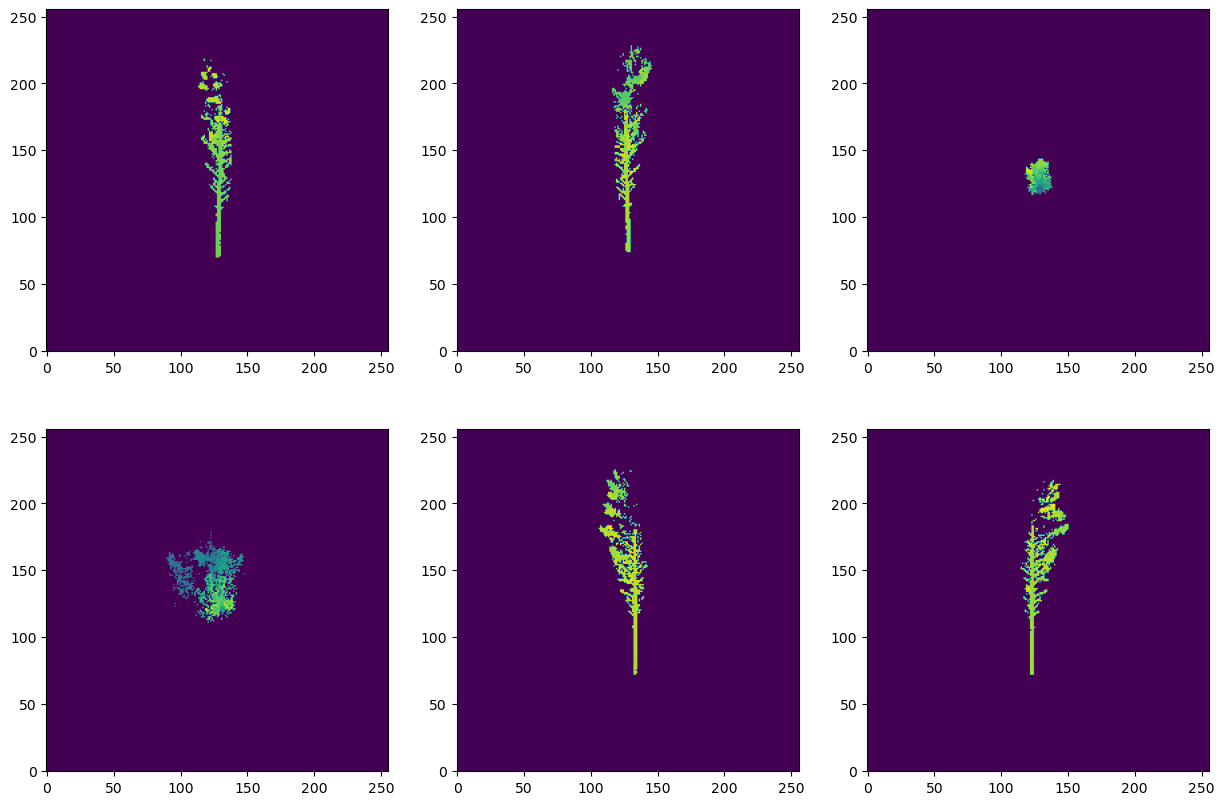

In [9]:
utils.plot_depth_images(val_dataset.__getitem__(54)['depth_images'])

In [10]:
val_dataset.meta_frame.head()

,id,sp,genus,dataset,data_type,tree_H,filename
0,19177,Fagus_sylvatica,Fagus,blueCat_ZF_species_las,TLS,10.31201,/train/19177.las
1,13716,Picea_abies,Picea,Frey_2022,TLS,31.97300,/train/13716.las
2,12043,Betula_pendula,Betula,puliti_MLS,MLS,5.20200,/train/12043.las
3,4283,Fagus_sylvatica,Fagus,wieser_ULS,ULS,10.26325,/train/04283.las
4,3894,Carpinus_betulus,Carpinus,wieser_ULS,ULS,12.95975,/train/03894.las


In [11]:
val_dataset.labels[:5]

tensor([10, 14,  4, 10,  5])

In [12]:
train_dataset.species == val_dataset.species

True

In [13]:
#val_dataset.species == test_dataset.species

In [2]:
species = ['Abies_alba',
 'Acer_campestre',
 'Acer_pseudoplatanus',
 'Acer_saccharum',
 'Betula_pendula',
 'Carpinus_betulus',
 'Corylus_avellana',
 'Crataegus_monogyna',
 'Eucalyptus_miniata',
 'Euonymus_europaeus',
 'Fagus_sylvatica',
 'Fraxinus_angustifolia',
 'Fraxinus_excelsior',
 'Larix_decidua',
 'Picea_abies',
 'Picea_glauca',
 'Pinus_contorta',
 'Pinus_nigra',
 'Pinus_pinaster',
 'Pinus_radiata',
 'Pinus_resinosa',
 'Pinus_sylvestris',
 'Populus_deltoides',
 'Populus_tremuloides',
 'Prunus_avium',
 'Pseudotsuga_menziesii',
 'Quercus_faginea',
 'Quercus_ilex',
 'Quercus_petraea',
 'Quercus_robur',
 'Quercus_rubra',
 'Tilia_cordata',
 'Ulmus_laevis']

First there are a few training parameters to specify - note that you should specify the species in your dataset you wish to include here. For example, 5 species are considered from our dataset. A single juniper tree and unidentified species are not included.:

In [23]:
params = {
    "batch_size":128,
    "shuffle_dataset":True,
    "random_seed":0,
    "learning_rate":[0.001,50,0.5],  #[init, step_size, gamma] for scheduler
    "momentum":0.9, #Only used for sgd, ignroed for adam
    "epochs":200,
    "loss_fn":"smooth-loss",
    "optimizer":"adam",
    "train_sampler":"balanced",

    "model":"SimpleView",

    "species":species,
}

Now we can train a model using the train/val/test datasets. If you try to rerun this cell without restarting the kernel, it might crash. If you use VS Code, it might hide some of the output.:

In [24]:
utils.train(train_data="data/Tr3D_species/comp_trees_train_512.pt",
            val_data="data/Tr3D_species/comp_trees_val_512.pt",
            test_data="data/Tr3D_species/comp_trees_val_512.pt",
            model_dir='models',
            params=params)

Device: cuda:0
Training data:
Pinus_sylvestris         2932
Fagus_sylvatica          2237
Picea_abies              1795
Carpinus_betulus         1126
Acer_campestre           1119
Quercus_faginea           912
Betula_pendula            671
Pseudotsuga_menziesii     601
Acer_pseudoplatanus       511
Pinus_nigra               414
Tilia_cordata             406
Quercus_petraea           329
Pinus_contorta            289
Quercus_ilex              266
Ulmus_laevis              258
Eucalyptus_miniata        258
Crataegus_monogyna        206
Quercus_robur             181
Quercus_rubra             147
Picea_glauca              146
Pinus_resinosa            146
Fraxinus_excelsior        114
Abies_alba                106
Acer_saccharum            100
Populus_tremuloides        95
Fraxinus_angustifolia      94
Euonymus_europaeus         93
Pinus_radiata              87
Pinus_pinaster             84
Larix_decidua              80
Populus_deltoides          51
Corylus_avellana           43
Prunus_avi

Now we can see the model predictions on the test dataset, and plot the confusion matrix:

['Abies_alba', 'Acer_campestre', 'Acer_pseudoplatanus', 'Acer_saccharum', 'Betula_pendula', 'Carpinus_betulus', 'Corylus_avellana', 'Crataegus_monogyna', 'Eucalyptus_miniata', 'Euonymus_europaeus', 'Fagus_sylvatica', 'Fraxinus_angustifolia', 'Fraxinus_excelsior', 'Larix_decidua', 'Picea_abies', 'Picea_glauca', 'Pinus_contorta', 'Pinus_nigra', 'Pinus_pinaster', 'Pinus_radiata', 'Pinus_resinosa', 'Pinus_sylvestris', 'Populus_deltoides', 'Populus_tremuloides', 'Prunus_avium', 'Pseudotsuga_menziesii', 'Quercus_faginea', 'Quercus_ilex', 'Quercus_petraea', 'Quercus_robur', 'Quercus_rubra', 'Tilia_cordata', 'Ulmus_laevis']


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5]),
 [Text(0, 0.5, 'Abies_alba'),
  Text(0, 1.5, 'Acer_campestre'),
  Text(0, 2.5, 'Acer_pseudoplatanus'),
  Text(0, 3.5, 'Acer_saccharum'),
  Text(0, 4.5, 'Betula_pendula'),
  Text(0, 5.5, 'Carpinus_betulus'),
  Text(0, 6.5, 'Corylus_avellana'),
  Text(0, 7.5, 'Crataegus_monogyna'),
  Text(0, 8.5, 'Eucalyptus_miniata'),
  Text(0, 9.5, 'Euonymus_europaeus'),
  Text(0, 10.5, 'Fagus_sylvatica'),
  Text(0, 11.5, 'Fraxinus_angustifolia'),
  Text(0, 12.5, 'Fraxinus_excelsior'),
  Text(0, 13.5, 'Larix_decidua'),
  Text(0, 14.5, 'Picea_abies'),
  Text(0, 15.5, 'Picea_glauca'),
  Text(0, 16.5, 'Pinus_contorta'),
  Text(0, 17.5, 'Pinus_nigra'),
  Text(0, 18.5, 'Pinus_pinaster'),
  Text(0, 19.5, 'Pinus_radiata'),
  Text(0, 20.5, 'Pinus_resinosa'),
  Text(0, 21.5, 'Pinus_sylvestri

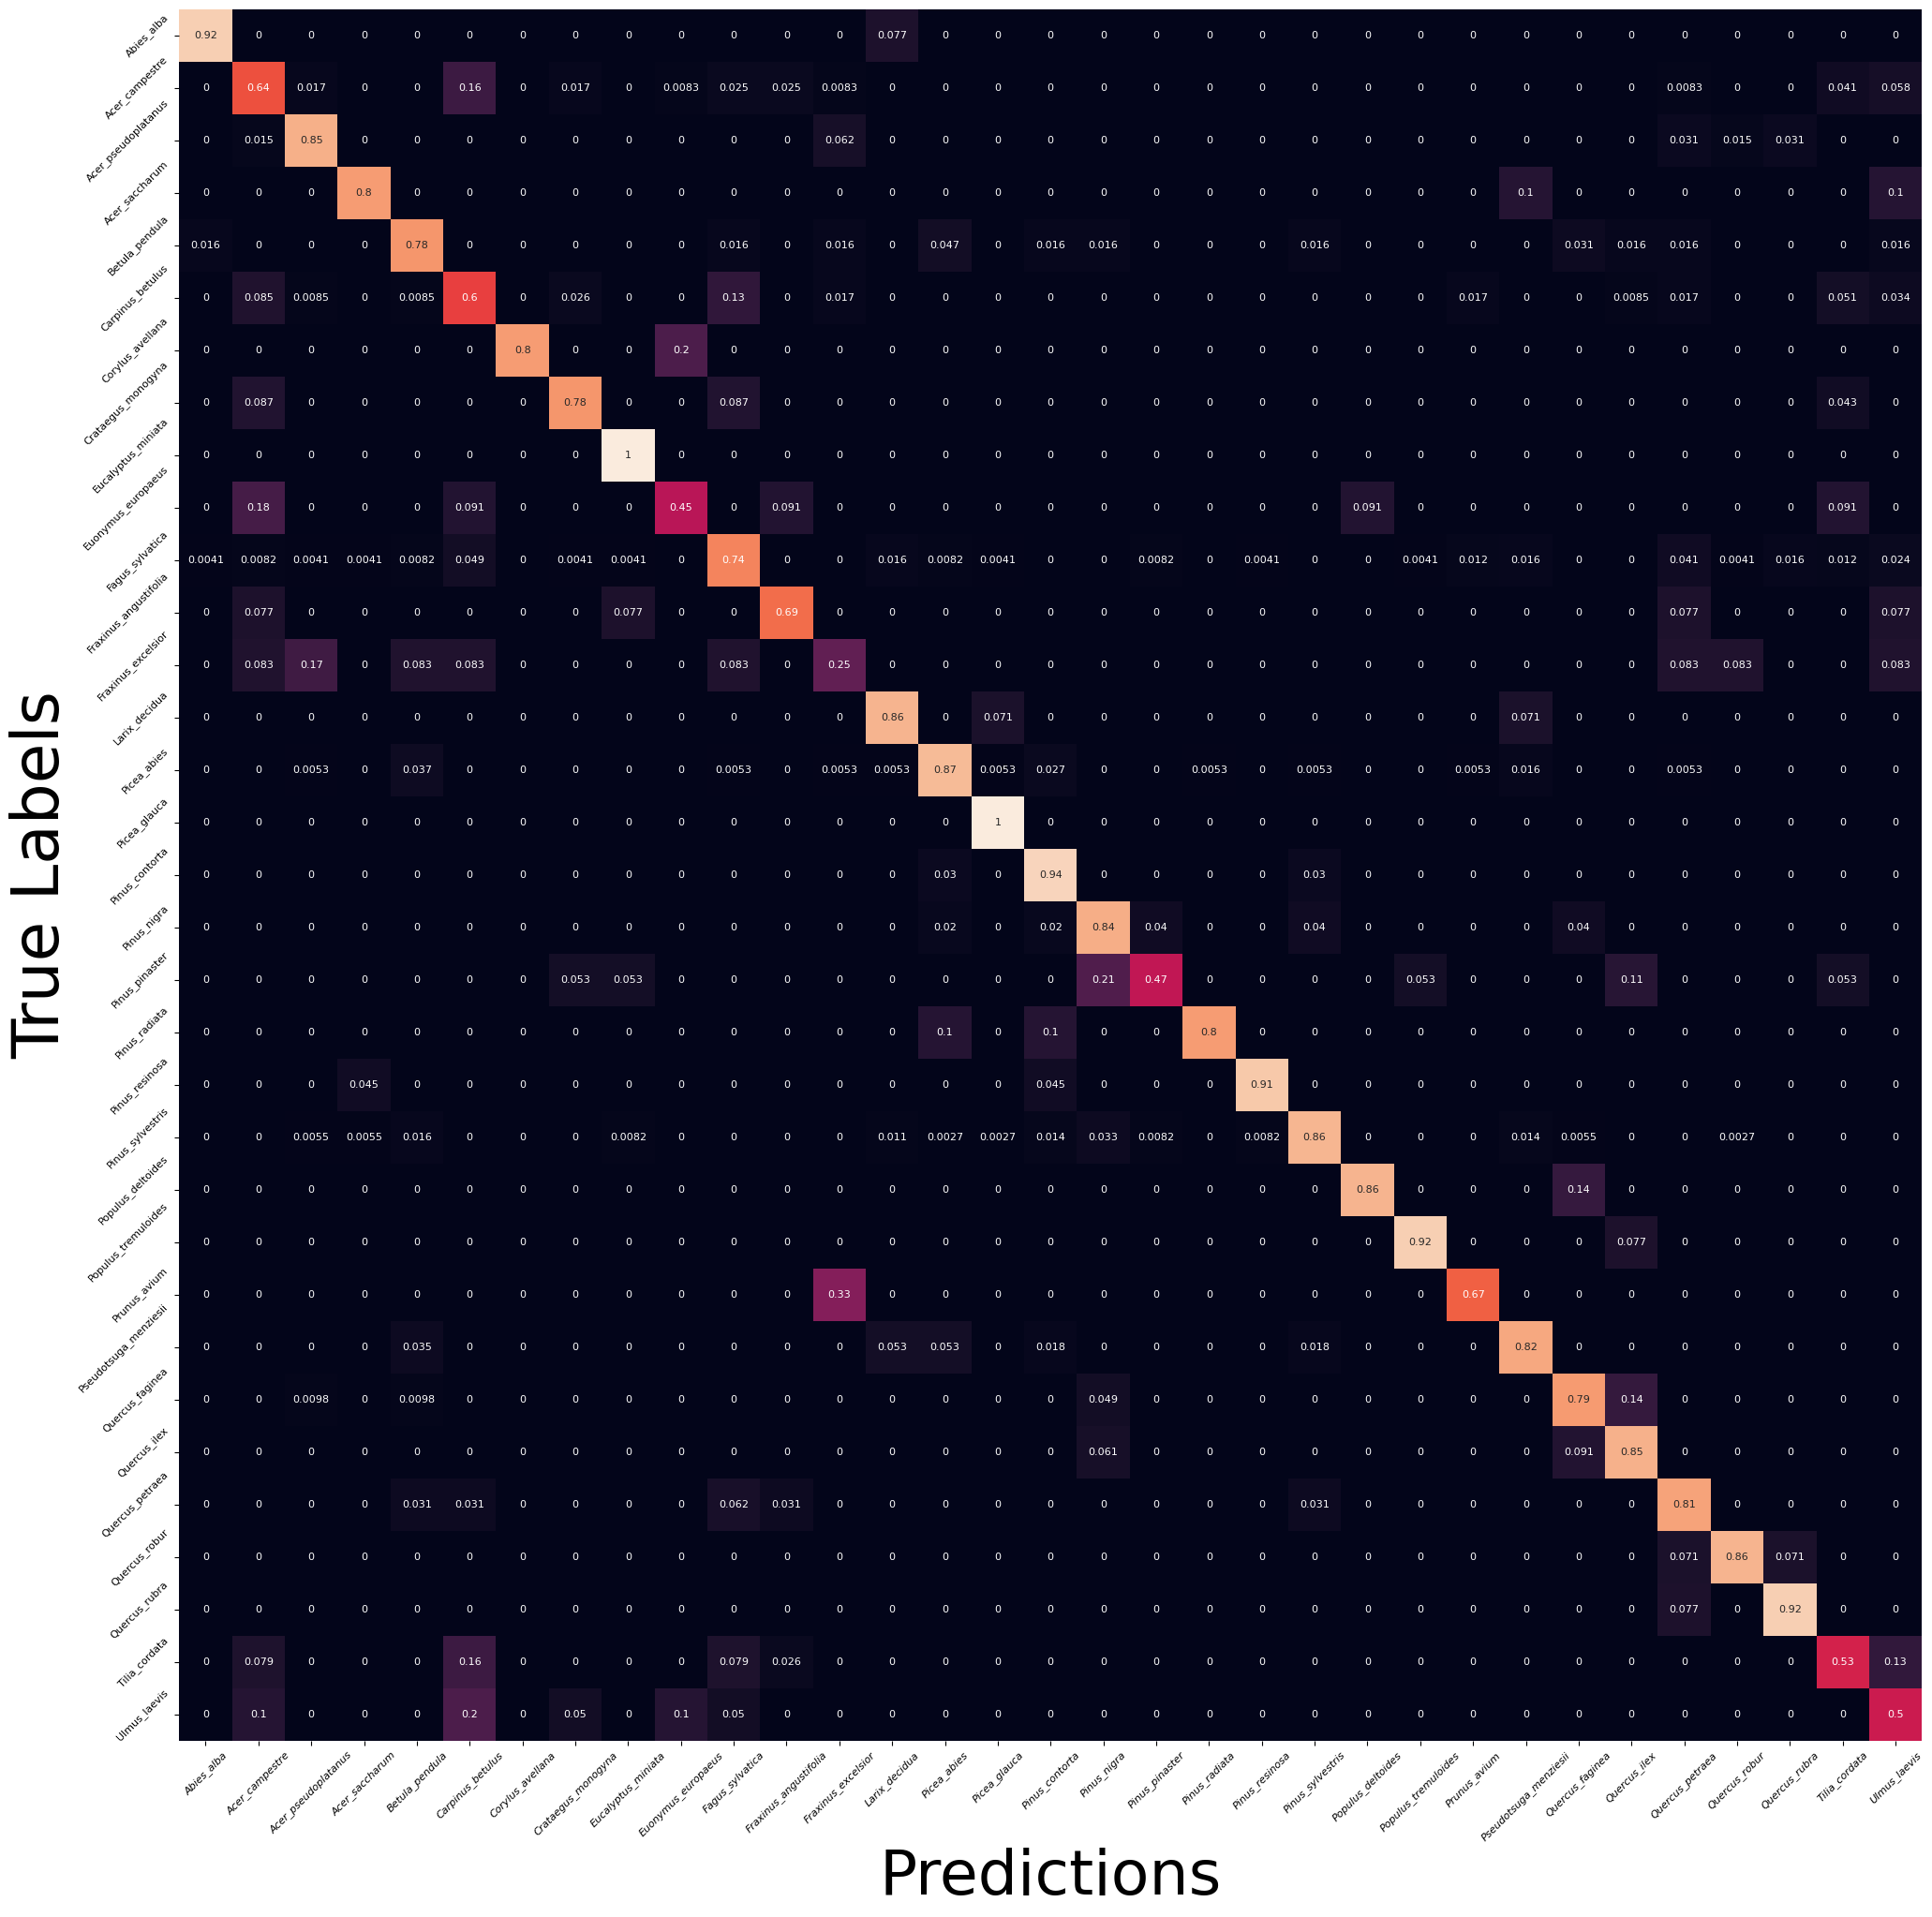

In [21]:
#models/2023-02-07 10:18:27.910618_best ####256
_, labels, predictions, species = utils.predict_from_dirs('data/Tr3D_species/comp_trees_val_256.pt', 'models/2023-02-07 10:18:27.910618_best', params={'species':species, 'num_views':6}) #Predictions for whole test dataset
print(species) #Might be in a different order to the one specified in the config

fig, ax = plt.subplots(1,1, figsize=(24,24))
tickFont = 8
axFont = 48
annotFont = 8

cm = confusion_matrix(labels.cpu(), predictions.cpu(), normalize='true')
hm = sns.heatmap(cm, annot=True, ax=ax, cbar=False, annot_kws={"fontsize":annotFont})
hm.set_xticklabels(species, fontsize=tickFont, style = 'italic')
ax.set_yticklabels(species, fontsize=tickFont)
hm.set_ylabel('True Labels', fontsize=axFont+2)
hm.set_xlabel('Predictions', fontsize=axFont)

plt.xticks(rotation=45)
plt.yticks(rotation=45)

In [5]:
#Construct a dataset with blank labels for competition entry
metadata_file = 'data/Tr3D_species_comp_test/meta/Tr3D_comp_meta.csv'
image_dim = 256

comp_dataset = utils.TreeSpeciesPointDataset(data_dir='data/Tr3D_species_comp_test/treesXYZ/', metadata_file=metadata_file)
comp_dataset.set_params(image_dim=image_dim)
torch.save(comp_dataset, f"data/Tr3D_species_comp_test/comp_trees_test_{image_dim}.pt")


100%|██████████| 2255/2255 [00:12<00:00, 179.92it/s]


['Abies_alba']


ValueError: The number of FixedLocator locations (33), usually from a call to set_ticks, does not match the number of ticklabels (1).

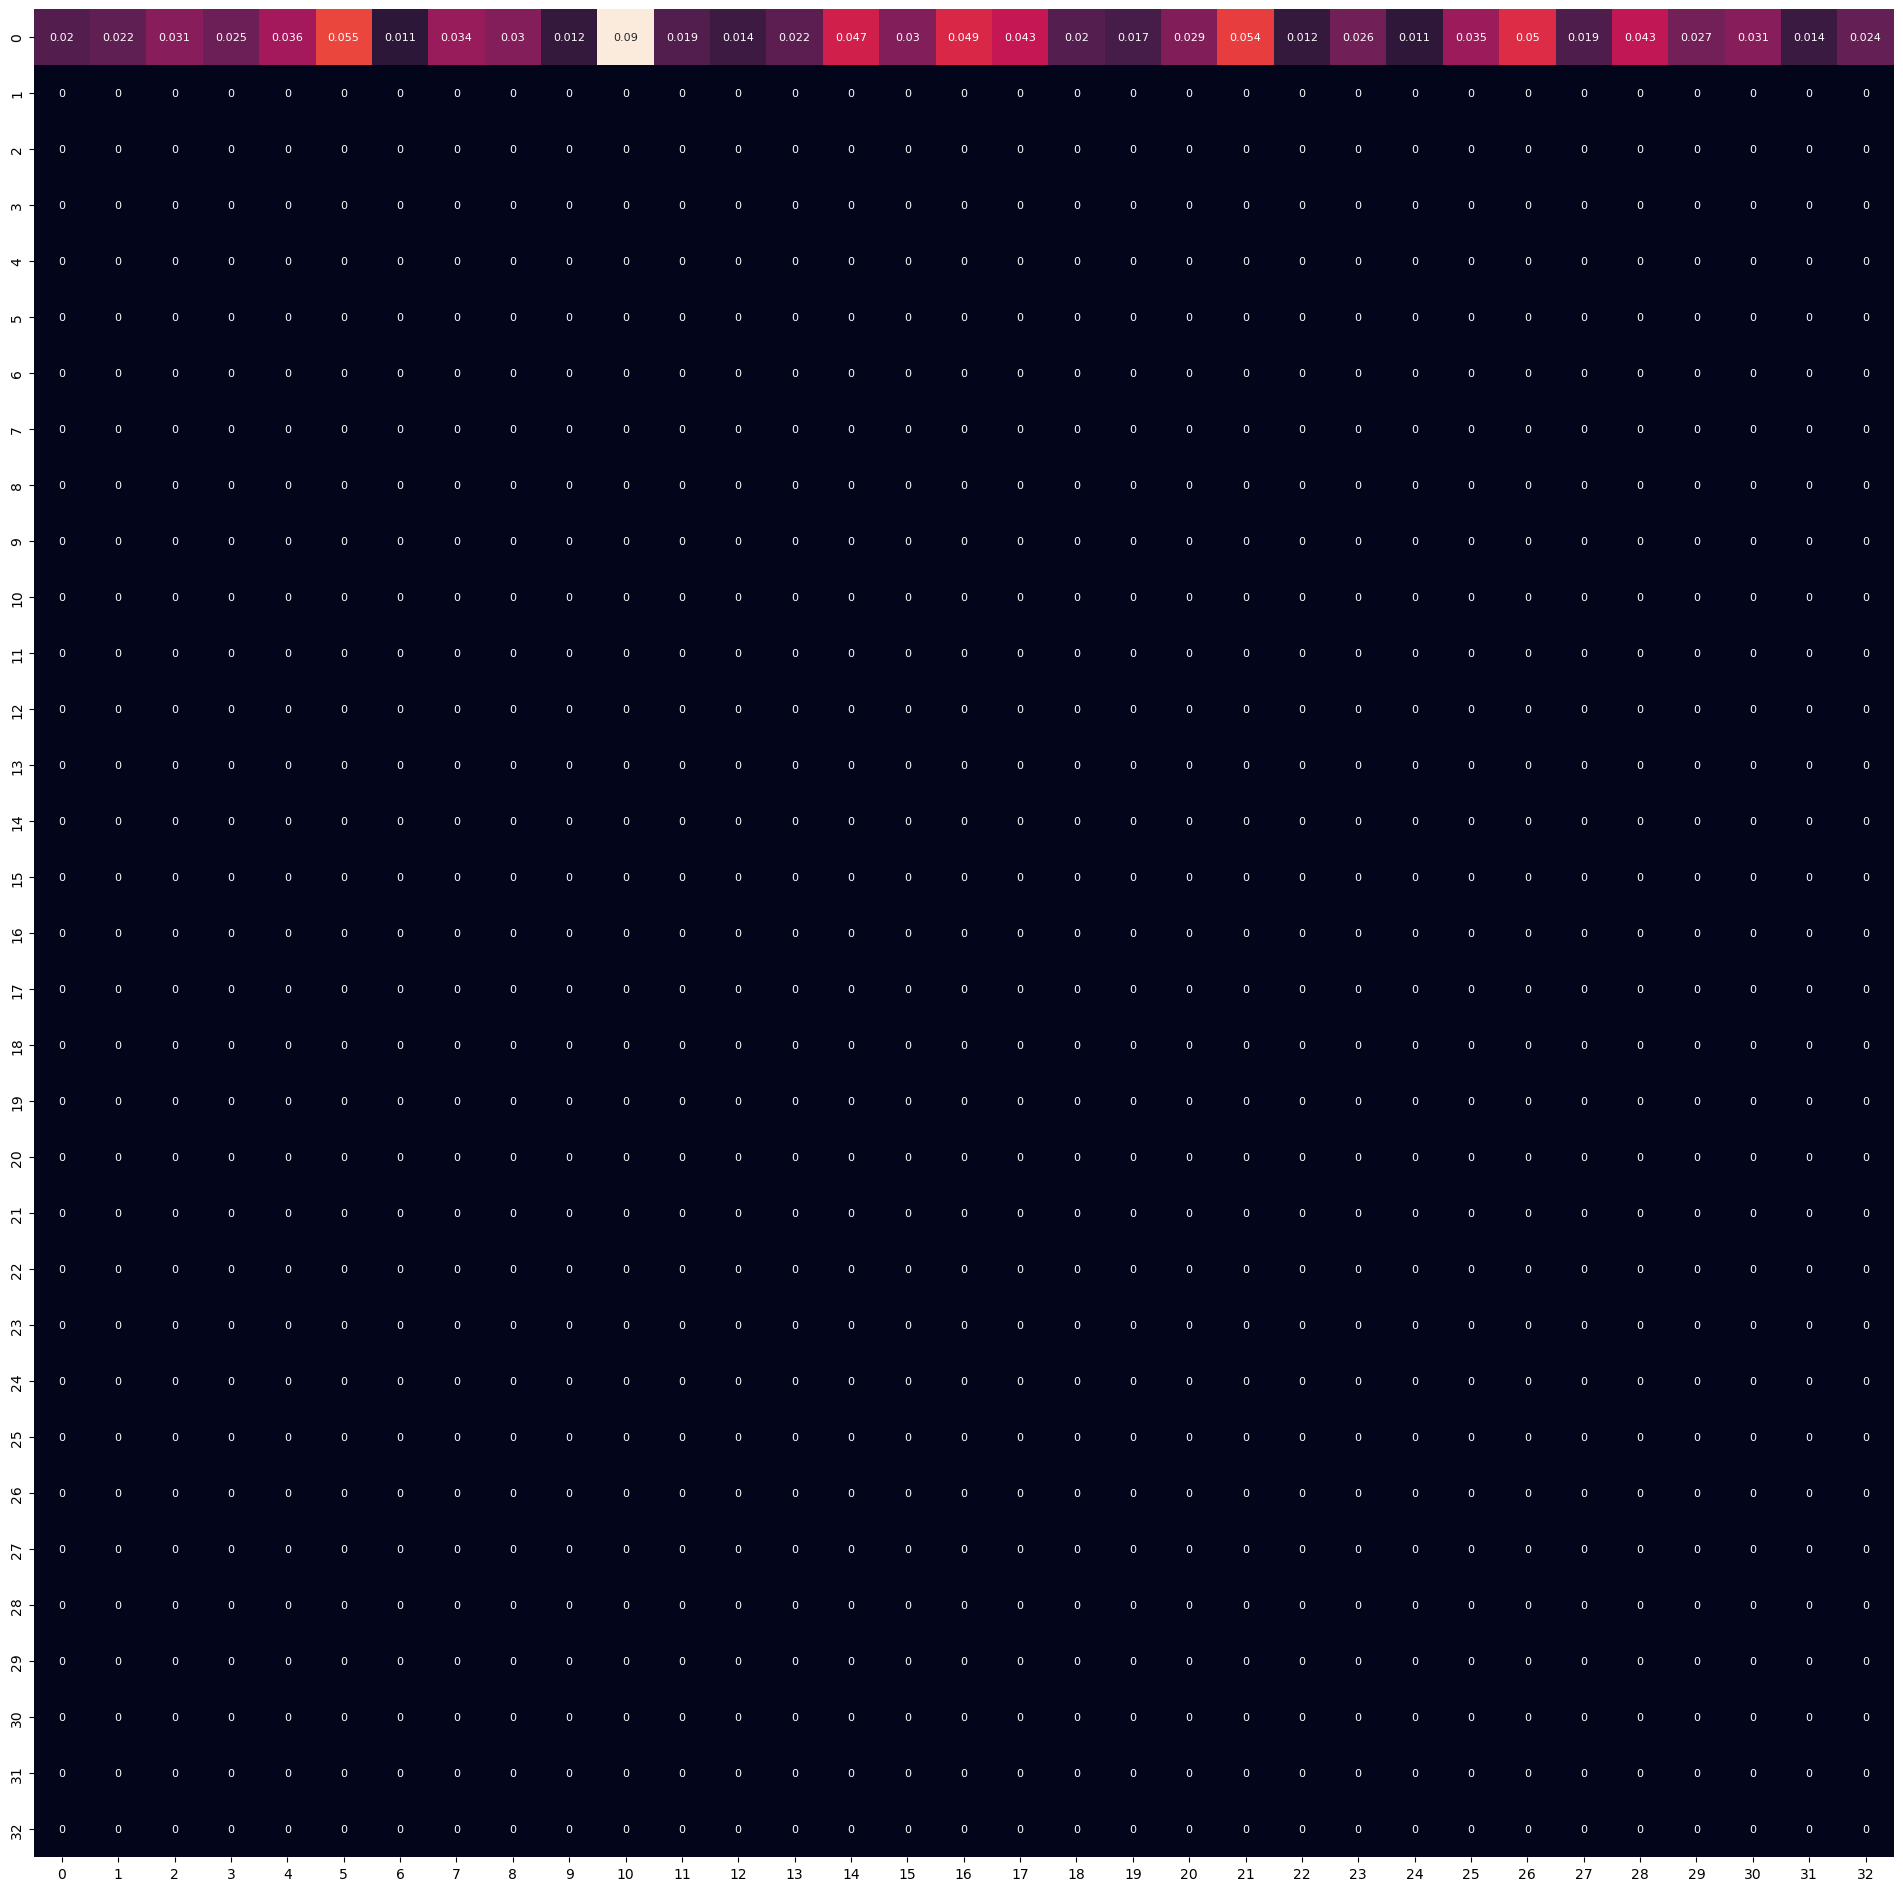

In [3]:
#models/2023-02-07 10:18:27.910618_best ####256
_, labels, predictions, _, ids = utils.predict_from_dirs('data/Tr3D_species_comp_test/comp_trees_test_256.pt', 'models/2023-02-07 10:18:27.910618_best', params={'species':species, 'num_views':6}, return_ids = True) #Predictions for whole test dataset
print(species) #Might be in a different order to the one specified in the config

fig, ax = plt.subplots(1,1, figsize=(24,24))
tickFont = 8
axFont = 48
annotFont = 8

cm = confusion_matrix(labels.cpu(), predictions.cpu(), normalize='true')
hm = sns.heatmap(cm, annot=True, ax=ax, cbar=False, annot_kws={"fontsize":annotFont})
hm.set_xticklabels(species, fontsize=tickFont, style = 'italic')
ax.set_yticklabels(species, fontsize=tickFont)
hm.set_ylabel('True Labels', fontsize=axFont+2)
hm.set_xlabel('Predictions', fontsize=axFont)

plt.xticks(rotation=45)
plt.yticks(rotation=45)

In [4]:
labels

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')

In [11]:
len(species)

1

In [10]:
max(predictions)

tensor(32., device='cuda:0')

In [6]:
ids

['8782',
 '3039',
 '18095',
 '11961',
 '4781',
 '17013',
 '9709',
 '13070',
 '7707',
 '6694',
 '18247',
 '7960',
 '6613',
 '10536',
 '3304',
 '10108',
 '10498',
 '447',
 '18068',
 '16647',
 '3074',
 '13629',
 '19630',
 '18081',
 '16951',
 '9011',
 '17342',
 '11657',
 '5246',
 '3967',
 '20084',
 '3661',
 '13584',
 '10247',
 '11321',
 '12667',
 '789',
 '7453',
 '13449',
 '8671',
 '1266',
 '12814',
 '17896',
 '4462',
 '727',
 '10531',
 '5986',
 '11433',
 '11971',
 '10703',
 '11409',
 '3757',
 '16960',
 '7769',
 '9557',
 '9074',
 '16544',
 '13366',
 '7113',
 '10377',
 '17019',
 '17983',
 '8103',
 '11213',
 '3625',
 '5814',
 '11873',
 '17254',
 '4125',
 '15219',
 '7466',
 '9037',
 '5590',
 '3819',
 '11429',
 '18147',
 '6075',
 '4219',
 '230',
 '17621',
 '12244',
 '8798',
 '16711',
 '3630',
 '11150',
 '13456',
 '3774',
 '16704',
 '4622',
 '18138',
 '10027',
 '3813',
 '6787',
 '8247',
 '10216',
 '16604',
 '17224',
 '11275',
 '9775',
 '16833',
 '6416',
 '1418',
 '17194',
 '7265',
 '6380',
 '17